# First look
Automated first look analysis of single cell RNA-seq data.
- Aim is to use scrna-functions to make a first pass and give an idea of data quality and content.
- We will assume that there has been a little bit of organising, i.e. combining data into one h5ad file with sample and groups in `adata.obs`.
- We will also assume that any metrics metadata will be pointed to, relative to `adata.h5ad`, with a per-sample dictionaryin `adata.uns['metrics_files']`.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import seaborn as sns
import matplotlib.pyplot as plt
import scrna_functions as scfunc
import sklearn.metrics
import argparse

from PIL import Image
from fpdf import FPDF
from pdf2image import convert_from_path
from fpdf import FPDF
import dataframe_image as dfi

%load_ext autoreload
%autoreload 2

## User input variables

In [2]:
# where the file is
file_path = Path('/Users/gkennedy/Library/CloudStorage/OneDrive-MalaghanInstituteofMedicalResearch/ongoing/Will_stroma_10x/lane7792/combined_samples_raw.h5ad')
file_path = Path('/Users/gkennedy/Desktop/pikor25-dendritic-cells.h5ad')

# where to save figures
figs_path = Path('./figures/firstlook/')

# independent samples, e.g. different patients
sample_col = 'sample'

# how samples are grouped, e.g. treatment, condition, disease, etc.
group_col = 'infect'

# use raw data? in case it has been log-normalized already
use_raw = False

In [3]:
# config for QC
max_mt_pct = 20.
max_top1_pct = 15.
min_genes = 200
min_cells = 3
pct_outlier_cutoff = 99.

# clustering
n_neighbours = 20
leiden_res = 0.8

## For exporting as a script
Add code here to allow export as a script, using argparse to overwrite the user input variables specified above.

In [4]:
"""
parser = argparse.ArgumentParser(description="First look at single-cell RNA-seq data")
parser.add_argument("--file_path", type=str, default=file_path, help="Path to the input .h5ad file")
parser.add_argument("--figs_path", type=str, default=figs_path, help="Path to save figures")
parser.add_argument("--sample_col", type=str, default=sample_col, help="Column name for independent samples")
parser.add_argument("--group_col", type=str, default=group_col, help="Column name for grouping samples")
parser.add_argument("--use_raw", action='store_true', default=use_raw, help="Use raw data if set")
parser.add_argument("--max_mt_pct", type=float, default=max_mt_pct, help="Max mitochondrial percentage for QC")
parser.add_argument("--max_top1_pct", type=float, default=max_top1_pct, help="Max top 1 gene percentage for QC")
parser.add_argument("--min_genes", type=int, default=min_genes, help="Min genes per cell for QC")
parser.add_argument("--min_cells", type=int, default=min_cells, help="Min cells per gene for QC")
parser.add_argument("--pct_outlier_cutoff", type=float, default=pct_outlier_cutoff, help="Percentile cutoff for outlier detection")
parser.add_argument("--n_neighbours", type=int, default=n_neighbours, help="Number of neighbours for clustering")
parser.add_argument("--leiden_res", type=float, default=leiden_res, help="Leiden clustering resolution")

args = parser.parse_args()

file_path = Path(args.file_path)
figs_path = Path(args.figs_path)
sample_col = args.sample_col
group_col = args.group_col
use_raw = args.use_raw
max_mt_pct = args.max_mt_pct
max_top1_pct = args.max_top1_pct
min_genes = args.min_genes
min_cells = args.min_cells
pct_outlier_cutoff = args.pct_outlier_cutoff
n_neighbours = args.n_neighbours
leiden_res = args.leiden_res
"""

'\nparser = argparse.ArgumentParser(description="First look at single-cell RNA-seq data")\nparser.add_argument("--file_path", type=str, default=file_path, help="Path to the input .h5ad file")\nparser.add_argument("--figs_path", type=str, default=figs_path, help="Path to save figures")\nparser.add_argument("--sample_col", type=str, default=sample_col, help="Column name for independent samples")\nparser.add_argument("--group_col", type=str, default=group_col, help="Column name for grouping samples")\nparser.add_argument("--use_raw", action=\'store_true\', default=use_raw, help="Use raw data if set")\nparser.add_argument("--max_mt_pct", type=float, default=max_mt_pct, help="Max mitochondrial percentage for QC")\nparser.add_argument("--max_top1_pct", type=float, default=max_top1_pct, help="Max top 1 gene percentage for QC")\nparser.add_argument("--min_genes", type=int, default=min_genes, help="Min genes per cell for QC")\nparser.add_argument("--min_cells", type=int, default=min_cells, help

## Setup

In [5]:
os.makedirs(figs_path, exist_ok=True)

## Read in data

In [6]:
rna = sc.read_h5ad(file_path)

# in case it wasn't already
rna.var_names_make_unique()
rna.obs_names_make_unique()

print(f'reading: {file_path}')
print(rna)

# todo: check if there is also VDJ or other data

reading: /Users/gkennedy/Desktop/pikor25-dendritic-cells.h5ad
AnnData object with n_obs × n_vars = 12378 × 33696
    obs: 'sample', 'genotype', 'infect', 'cell_type', 'group'
    uns: 'metrics_summary'


In [7]:
# maybe we want to use raw?
if use_raw:
    rna.X = rna.raw.X
else:
    rna.raw = rna.copy()

In [8]:
# sample details
if 'sample_order' in rna.uns:
    sample_order = rna.uns['sample_order']
else:
    sample_order = sorted(rna.obs[sample_col].unique().tolist())

sample_numbers = {s: i+1 for i, s in enumerate(sample_order)}
rna.obs['samp_no'] = pd.Categorical(rna.obs[sample_col].map(sample_numbers))
sample_number_order = [sample_numbers[s] for s in sample_order]

In [9]:
# assume each sample belongs to a unique group (e.g. infected vs control)
if group_col != '':
    groups = rna.obs[group_col].unique().tolist()
    sample_group_mapping = {}
    for g in groups:
        samples_in_group = rna.obs.loc[rna.obs[group_col] == g, sample_col].unique().tolist()
        for s in samples_in_group:
            if s in sample_group_mapping.keys():
                raise ValueError(f'Sample {s} appears in multiple groups!')
            sample_group_mapping[s] = g

## Guess whether human or mouse

In [10]:
organism = scfunc.guess_human_or_mouse(rna)
print(f'assuming organism: {organism}')

assuming organism: mouse


## Metrics
Try to use metrics files, otherwise use a few things we know from adata.

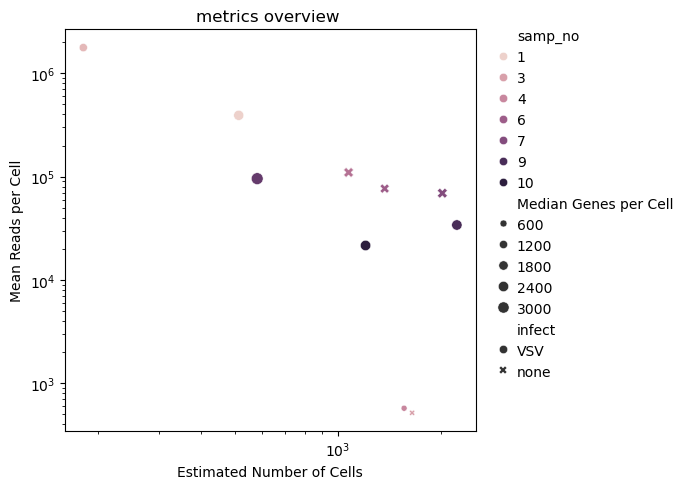

In [11]:
if 'metrics_summary' in rna.uns:
    metrics = []
    # for s, df in rna.uns['metrics_summary'].items():
    for s in sample_order:
        df = rna.uns['metrics_summary'][s]
        metrics.append(df)
        metrics[-1]['sample'] = s
        metrics[-1]['samp_no'] = [sample_numbers[s]]
        metrics[-1][group_col] = sample_group_mapping[s] if group_col != '' else ''
        # convert to float if possible
        for c in metrics[-1].columns:
            try:
                metrics[-1][c] = metrics[-1][c].str.replace(',', '', regex=False).str.replace('%', '', regex=False).astype(float)
            except:
                pass

    metrics = pd.concat(metrics)
    metrics.set_index('samp_no', inplace=True)

    keep_cols = ['sample', group_col, 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Total Genes Detected',
                'Valid Barcodes', 'Reads Mapped Confidently to Genome', 'Sequencing Saturation']

    metrics_table = metrics[keep_cols]

    # diagnostic plot for outliers
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(metrics_table, x='Estimated Number of Cells', y='Mean Reads per Cell', size='Median Genes per Cell',
                    hue=metrics_table.index, style=group_col, legend=True, ax=ax)

else:
    metrics_table = pd.DataFrame({'sample': sample_order, 
                                  'Estimated Number of Cells': rna.obs[sample_col].value_counts().reindex(sample_order).values,
                                  'Total Genes Detected': [rna[rna.obs[sample_col] == s].n_vars for s in sample_order]})
    metrics_table['samp_no'] = metrics_table['sample'].map(sample_numbers)
    metrics_table['group'] = metrics_table['sample'].map(sample_group_mapping) if group_col != '' else ''
    metrics_table.set_index('samp_no', inplace=True)

    # diagnostic plot for outliers
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(metrics_table, x='Estimated Number of Cells', y='Total Genes Detected',
                    hue=metrics_table.index, style='group', legend=True, ax=ax)

ax.set_title(f"metrics overview {'(basic)' if 'metrics_summary' not in rna.uns else ''}")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.tight_layout()
fig.savefig(str(figs_path / 'metrics_scatter.pdf'))

## Quality control

In [12]:
scfunc.filter_cells_genes(rna)
scfunc.compute_qc_metrics(rna)

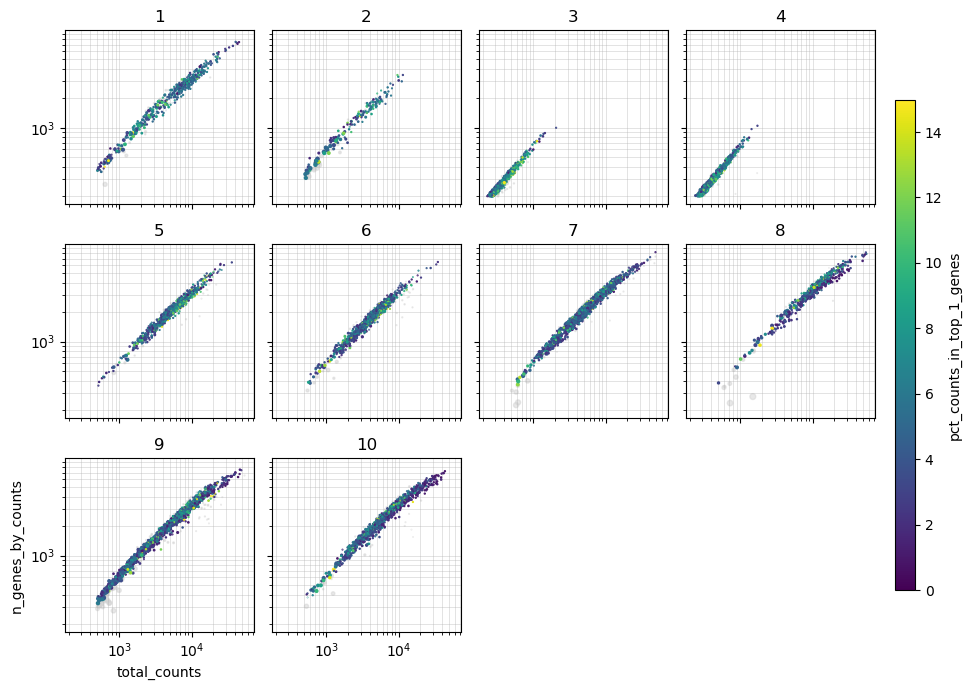

In [13]:
mask = scfunc.trim_outliers(
    rna,
    groupby=sample_col,
    extra_mask={
        'pct_counts_mt': [max_mt_pct, 'max'],
        'pct_counts_in_top_1_genes': [max_top1_pct, 'max']
    },
    pct=pct_outlier_cutoff,
)

fig = scfunc.plot_gene_counts(rna, hue='samp_no', order=sample_number_order, mask=mask, show_masked=True)
fig.savefig(str(figs_path / 'gene_counts_per_sample.pdf'))

In [14]:
# apply mask
rna = rna[mask, :].copy()

## Doublets

In [15]:
sc.pp.scrublet(rna, batch_key=sample_col)

## Cell cycle

In [16]:
cell_cycle_genes = scfunc.get_cell_cycle_genes(organism, gene_list=rna.var_names)
sc.tl.score_genes_cell_cycle(rna, s_genes=cell_cycle_genes['s_genes'], g2m_genes=cell_cycle_genes['g2m_genes'])

Missing S phase genes: ['Mlf1ip']
Missing G2M phase genes: ['Fam64a', 'Hn1']


## Preprocessing steps

In [17]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna)

# sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna)

# batch correction using Harmony
sc.external.pp.harmony_integrate(rna, key=sample_col)

2025-09-22 15:58:48,510 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-22 15:58:48 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-22 15:58:49,242 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-22 15:58:49 | [INFO] sklearn.KMeans initialization complete.
2025-09-22 15:58:49,282 - harmonypy - INFO - Iteration 1 of 10
2025-09-22 15:58:49 | [INFO] Iteration 1 of 10
2025-09-22 15:58:50,296 - harmonypy - INFO - Iteration 2 of 10
2025-09-22 15:58:50 | [INFO] Iteration 2 of 10
2025-09-22 15:58:51,426 - harmonypy - INFO - Converged after 2 iterations
2025-09-22 15:58:51 | [INFO] Converged after 2 iterations


In [18]:
sc.pp.neighbors(rna, n_neighbors=n_neighbours, use_rep="X_pca_harmony")
sc.tl.umap(rna, random_state=42)
sc.tl.leiden(rna, resolution=leiden_res)

## Batch correction metric
Use silhouette score $s(i)$ to see how well batches mix, do this per leiden cluster (similar to Leucken et al 2021, who do it by cell type).

Their method is:
- per batch, compute: batch_ASW = 1/(n_cells) * sum_over_i_cells(1-s(i))
- then average these, i.e. 1/(n_batches) * sum_over_batches(batch_ASW)

In [27]:
batch_s_original = []
batch_s_corrected = []
for s in sample_order:
    tmp = rna[rna.obs[sample_col] == s].copy()
    scores = 1 - sklearn.metrics.silhouette_samples(tmp.obsm['X_pca'], tmp.obs['leiden'])
    batch_s_original.append(scores.sum() / len(scores))
    scores = 1 - sklearn.metrics.silhouette_samples(tmp.obsm['X_pca_harmony'], tmp.obs['leiden'])
    batch_s_corrected.append(scores.sum() / len(scores))

asw_original = np.mean(batch_s_original)
asw_corrected = np.mean(batch_s_corrected)
print(f'ASW original: {asw_original:.4f}, ASW corrected: {asw_corrected:.4f}')

ASW original: 0.9066, ASW corrected: 0.9068


## UMAPs

In [19]:
# fix this (again)
rna.obs['samp_no'] = pd.Categorical(rna.obs['samp_no'])

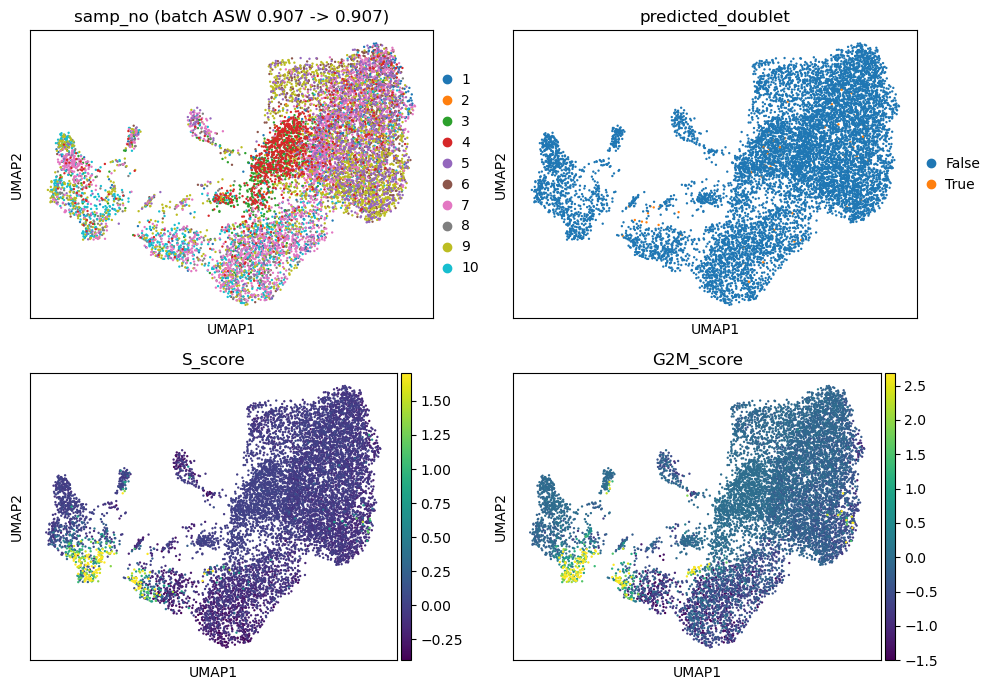

In [ ]:
fig , ax = plt.subplots(2, 2, figsize=(10,7))
for i, x in enumerate(zip(['samp_no', 'predicted_doublet', 'S_score', 'G2M_score'],
                          [False, False, True, True])):
    col, vminmax = x
    vmin, vmax = None, None
    if vminmax:
        vmin, vmax = np.percentile(rna.obs[col], (1, 99))
    sc.pl.umap(rna, color=col, vmin=vmin, vmax=vmax,
               ax=ax[i//2, i%2], show=False)
    if i == 0:
        ax[i//2, i%2].set_title(f'samp_no (batch ASW {asw_original:.3f} -> {asw_corrected:.3f})')

fig.tight_layout()
fig.savefig(str(figs_path / 'umap_overview.pdf'))

## cell types

### decoupler/PanglaoDB

In [21]:
# decoupler
markers = dc.op.resource("PanglaoDB", organism=organism)

# Filter by canonical_marker and human
markers = markers[
    markers[organism].astype(bool)
    & markers["canonical_marker"].astype(bool)
    & (markers[f"{organism}_sensitivity"].astype(float) > 0.5)
]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target", f"{organism}_sensitivity": "weight"})
markers = markers[["source", "target", "weight"]]

dc.mt.ulm(rna, markers, verbose=False)
score = dc.pp.get_obsm(rna, key="score_ulm")
df = dc.tl.rankby_group(adata=score, groupby="leiden", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
dict_ann = df[df["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
rna.obs['celltype_panglao'] = rna.obs["leiden"].map(dict_ann)

### celltypist

In [22]:
scfunc.celltypist_annotate_immune(rna)

2025-09-18 09:29:50 | [INFO] 🔬 Input data has 10346 cells and 22107 genes
2025-09-18 09:29:50 | [INFO] 🔗 Matching reference genes in the model
2025-09-18 09:29:50 | [INFO] 🔗 Matching reference genes in the model
2025-09-18 09:29:51 | [INFO] 🧬 4544 features used for prediction
2025-09-18 09:29:51 | [INFO] ⚖️ Scaling input data
2025-09-18 09:29:51 | [INFO] 🧬 4544 features used for prediction
2025-09-18 09:29:51 | [INFO] ⚖️ Scaling input data
2025-09-18 09:29:51 | [INFO] 🖋️ Predicting labels
2025-09-18 09:29:51 | [INFO] 🖋️ Predicting labels
2025-09-18 09:29:51 | [INFO] ✅ Prediction done!
2025-09-18 09:29:51 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-09-18 09:29:51 | [INFO] ⛓️ Over-clustering input data with resolution set to 10
2025-09-18 09:29:51 | [INFO] ✅ Prediction done!
2025-09-18 09:29:51 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-09-18 09:29:51 | [

### cell type umaps

... storing 'celltype_panglao' as categorical


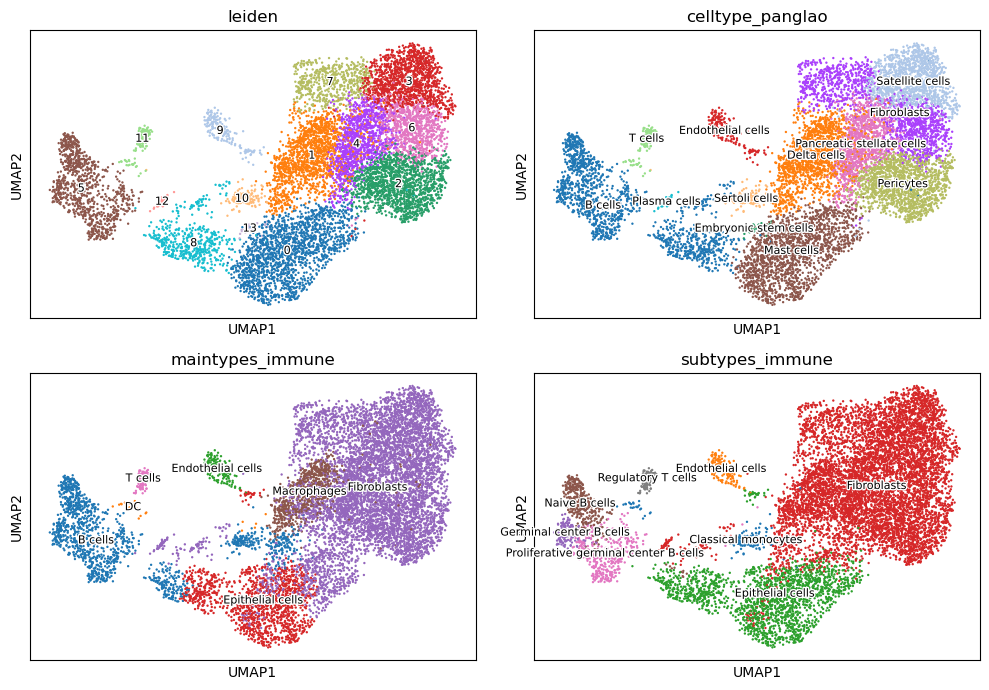

In [23]:
fig , ax = plt.subplots(2, 2, figsize=(10,7))
for i, x in enumerate(zip(['leiden', 'celltype_panglao', 'maintypes_immune', 'subtypes_immune'],
                          [True, True, True, True])):
    col, show_legend = x
    sc.pl.umap(rna, color=col, ncols=2,
               legend_loc='on data' if show_legend else True, legend_fontsize=8, legend_fontoutline=2, legend_fontweight='normal',
               ax=ax[i//2, i%2], show=False)
fig.tight_layout()
fig.savefig(str(figs_path / 'umap_celltypes.pdf'))

### specific markers
Add some specific, somewhat niche, marker genes we might be interested in.

Missing genes in FDC - primary: ['Fdcsp']


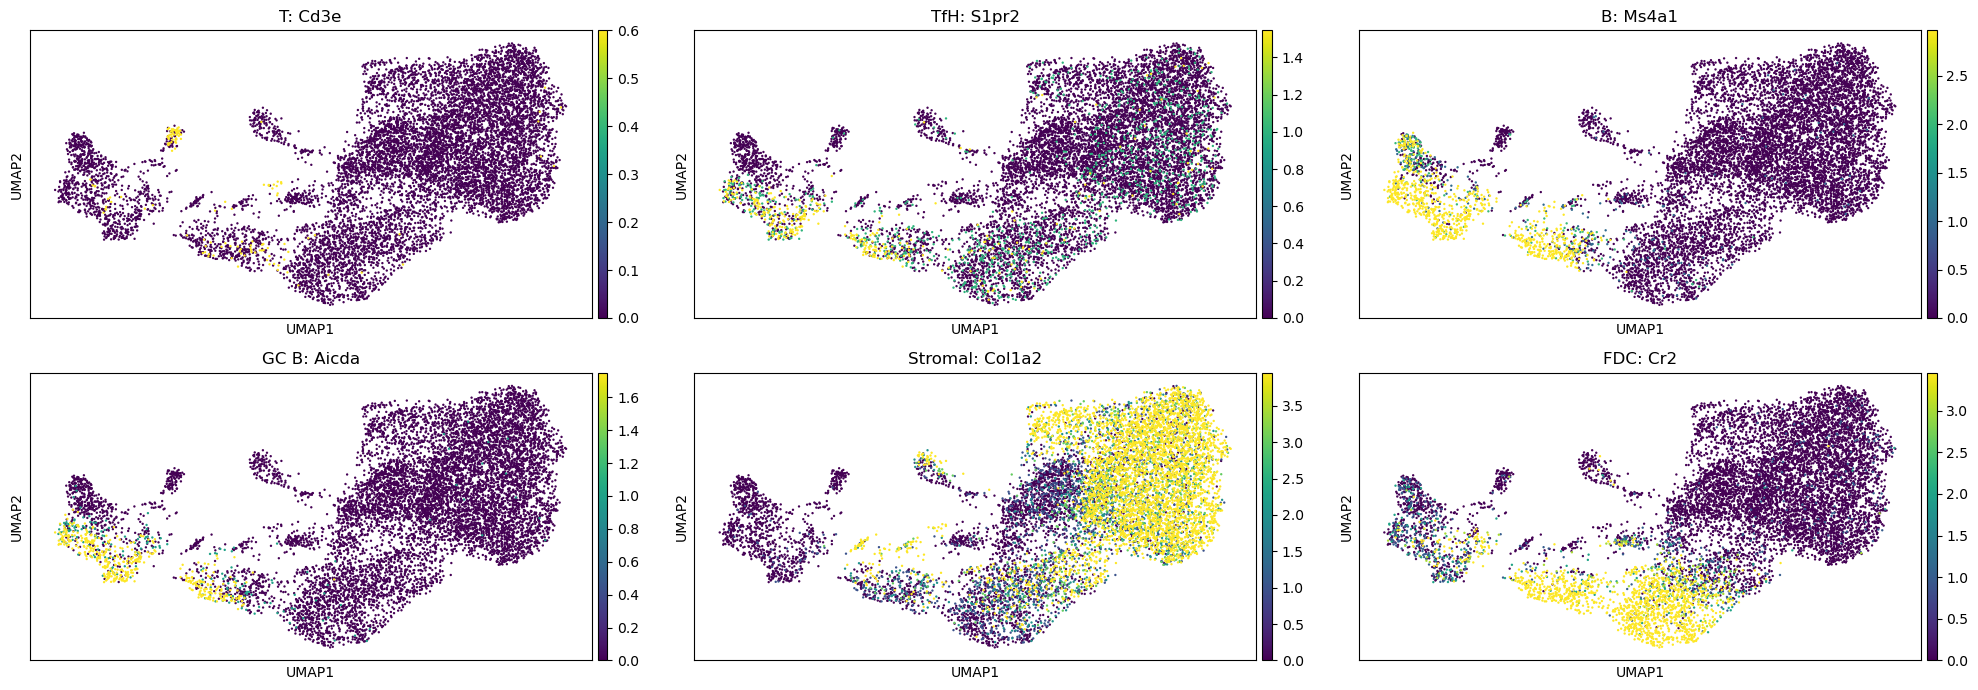

In [24]:
# marker genes, we want the most specific one for each of T, TfH, B, GC B, Stromal, FDC
marker_genes = {
    "T": {'genes': ["CD3E", "CD3D", "TRAC"]},
    "TfH": {'genes': ["S1PR2", "CXCR5", "PDCD1"]},
    "B": {'genes': ["MS4A1", "CD79A", "CD19"]},
    "GC B": {'genes': ["AICDA", "S1PR2", "PCNA"]},
    "Stromal": {'genes': ["COL1A2", "PDGFRA", "VIM"]},
    "FDC": {'genes': ["CR2", "FDCSP", "CXCL13"]}
}
markers = scfunc.celltypemarkers.CellTypeMarkers(organism=organism,data=marker_genes)
markers.filter_genes(rna.var_names)
marker_genes = markers.to_dict()

fig, ax = plt.subplots(2, 3, figsize=(20, 7))
for i, k in enumerate(marker_genes.keys()):
    a = ax.flatten()[i]
    gene = marker_genes[k][0]
    vmax = scfunc.get_vmax(rna, [gene], percentile=99)
    sc.pl.umap(rna, color=gene, vmax=vmax, ax=a, show=False)
    a.set_title(f'{k}: {gene}')

fig.tight_layout()
fig.savefig(figs_path / 'umap_markers.pdf')

## Generate summary
Use fpdf2 to make a report with four panels on an a4 page
- top left: metrics table
- bottom left: gene_counts_per_sample.pdf
- top right: umap_overview.pdf
- bottom right: umap_celltypes.pdf

In [ ]:
# Save metrics_table as an image
metrics_table_path = figs_path / "metrics_table.png"
with open(metrics_table_path, 'wb') as f:
    try:
        dfi.export(metrics_table, f)
    except:
        dfi.export(metrics_table, f, table_conversion='matplotlib')

# Prepare file paths for images
pdfs = ['metrics_scatter', 'gene_counts_per_sample', 'umap_overview', 'umap_celltypes',
        'umap_markers']
pdf_paths = {}
png_paths = {}
for pdf in pdfs:
    pdf_paths[pdf] = figs_path / f"{pdf}.pdf"
    png_paths[pdf] = figs_path / f"{pdf}.png"

# Convert PDFs to PNGs for FPDF (if needed)
def pdf_to_png(pdf_path, out_path):
    images = convert_from_path(str(pdf_path), dpi=150)
    images[0].save(out_path, 'PNG')

for k in pdf_paths.keys():
    pdf_to_png(pdf_paths[k], png_paths[k])

# Create PDF report
pdf = FPDF(orientation='L', unit='mm', format='A4')
pdf.add_page()

page_w, page_h = pdf.w, pdf.h
margin_x, margin_y = 1, 1

# Add title and subtitle to the PDF page
title = file_path.name
subtitle = str(file_path.resolve())

pdf.set_font("Helvetica", "", 10)
pdf.set_x(margin_x)
pdf.cell(page_w - 2 * margin_x, 2, subtitle, align="C", new_y='NEXT')
title_h = pdf.get_y() + 2

# Panel positions and sizes
panel_w, panel_h = (page_w - 2 * margin_x) / 2, (page_h - 2 * margin_y - title_h) / 2

pdf.image(str(metrics_table_path), x=margin_x, y=margin_y + title_h, w=panel_w, h=panel_h/2, keep_aspect_ratio=True)
pdf.image(str(png_paths['metrics_scatter']), x=margin_x, y=margin_y + title_h + panel_h/2, w=panel_w/2, h=panel_h/2, keep_aspect_ratio=True)

pdf.image(str(png_paths['gene_counts_per_sample']), x=margin_x, y=margin_y + title_h + panel_h, w=panel_w, h=panel_h)
pdf.image(str(png_paths['umap_overview']), x=margin_x + panel_w, y=margin_y + title_h, w=panel_w, h=panel_h)
pdf.image(str(png_paths['umap_celltypes']), x=margin_x + panel_w, y=margin_y + panel_h + title_h, w=panel_w, h=panel_h)

# second page with more specific stuff
pdf.add_page()
pdf.image(str(png_paths['umap_markers']), x=margin_x, y=margin_y, w=panel_w * 2, h=panel_h)

report_path = figs_path / "firstlook_report.pdf"
pdf.output(str(report_path))
print(f"Report saved to {report_path}")

82791 bytes written to file /var/folders/mg/0dy5ly3x2196rs28xt2by2zm0000gq/T/tmpwjcbi80s/temp.png
83019 bytes written to file /var/folders/mg/0dy5ly3x2196rs28xt2by2zm0000gq/T/tmpqsngmbpi/temp.png
83019 bytes written to file /var/folders/mg/0dy5ly3x2196rs28xt2by2zm0000gq/T/tmpqsngmbpi/temp.png


Report saved to figures/firstlook/firstlook_report.pdf
